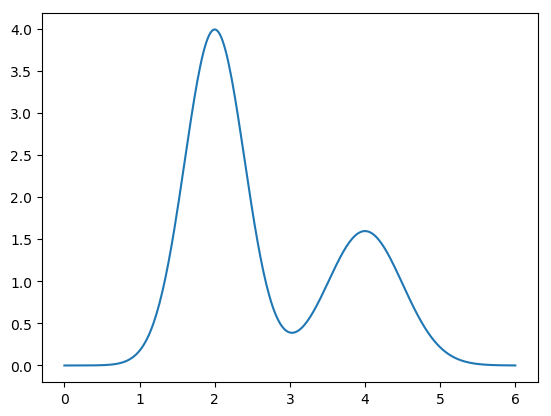

In [1]:
using PyCall
include("src/gauss_error.jl")
include("src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

# function phi(x::Float64)
#     return cos(x)
# end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))
savefig("function.png", dpi=1000)

In [2]:
function kernel(x::Float64, y::Float64)
    return getOpticsKernels("gaussian")(x, y)
end

kernel (generic function with 1 method)

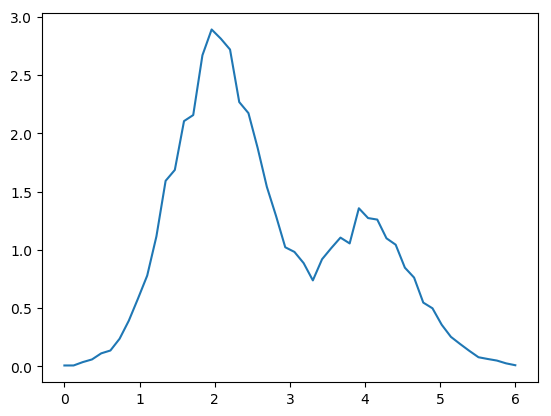

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, maxevals=10^7)[1]
y = collect(range(a, stop = b, length=50))
ftrue = convolution.(y)
sig = 0.05*abs.(ftrue) +[0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f)
savefig("integrated_function.png", dpi=1000)

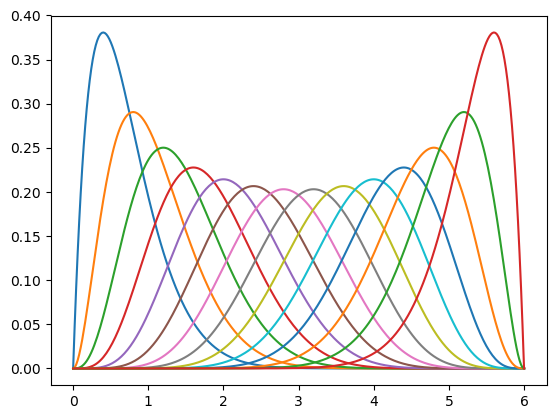

1.0
15.0
105.0
455.0
1365.0
3003.0
5005.0
6435.0
6435.0
5005.0
3003.0
1365.0
455.0
105.0
15.0
1.0


In [4]:
basis = BernsteinBasis(a, b, 15, "dirichlet")
for basis_function in basis.basis_functions
    plot(x, basis_function.f.(x))
end
savefig("basis.png", dpi=1000)

In [5]:
# @time discretize_kernel(basis, kernel, y)

Kmn = discretize_kernel(basis, kernel, y)

50×14 Array{Float64,2}:
 0.141218     0.0675665   0.0279057   0.0100655    …  1.18697e-9  5.85963e-11
 0.176767     0.0929655   0.0417248   0.01623         3.26357e-9  1.69696e-10
 0.208706     0.121101    0.0592081   0.0248802       8.60242e-9  4.71485e-10
 0.233167     0.14978     0.0799427   0.0363471       2.17724e-8  1.25872e-9 
 0.247345     0.176423    0.102981    0.0507253       5.29943e-8  3.23383e-9 
 0.250075     0.198527    0.126912    0.0677928    …  1.2424e-7   8.00753e-9 
 0.241925     0.214114    0.150044    0.0869787       2.80974e-7  1.91391e-8 
 0.224849     0.222039    0.170646    0.107389        6.13894e-7  4.42205e-8 
 0.201579     0.222096    0.18719     0.127892        1.2977e-6   9.89081e-8 
 0.174995     0.214923    0.198557    0.147242        2.65783e-6  2.14464e-7 
 0.147635     0.201778    0.204143    0.164227     …  5.28134e-6  4.51421e-7 
 0.121428     0.184254    0.203884    0.177799        1.01953e-5  9.23598e-7 
 0.0976351    0.164019    0.198194    0.

In [6]:
model = GaussErrorMatrixUnfolder(omega(basis, 2))

GaussErrorMatrixUnfolder(Array{Float64,2}[[49.3025 48.4707 … 0.00124471 0.000166494; 48.4707 56.9168 … 0.0082847 0.00124471; … ; 0.00124471 0.0082847 … 56.9168 48.4707; 0.000166494 0.00124471 … 48.4707 49.3025]], 14, "EmpiricalBayes", nothing)

starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
Iter     Function value   Gradient norm 
     0    -8.459165e+01     8.240705e+01
     1    -4.615301e+02     2.021113e+01
     2    -5.618077e+02     1.795545e+01
     3    -7.532873e+02     8.715655e+00
     4    -7.560510e+02     7.484959e+00
     5    -7.605787e+02     3.946478e+00
     6    -7.614149e+02     8.720897e-01
     7    -7.614408e+02     1.527914e-01
     8    -7.614406e+02     3.317107e-02
     9    -7.614406e+02     2.276380e-01
    10    -7.614407e+02     1.694056e-01
    11    -7.614407e+02     3.721619e-01
    12    -7.614406e+02     2.085949e-01
    13    -7.614408e+02     3.602676e-02
    14    -7.614400e+02     5.191157e-03
    15    -7.614400e+02     7.299662e-02
    16    -7.614400e+02     1.746795e-01
    17    -7.614406e+02     4.754635e-01
    18    -7.614403e+02     1.857009e-01
    19    -7.614399e+02     9.386411e-02
    20    -7.614394e+02     3.158018e-02
    21

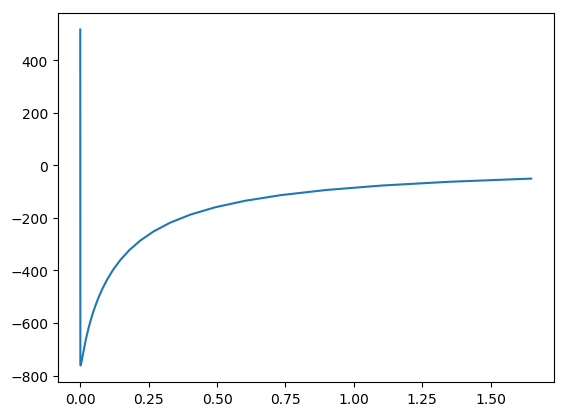

ending solve_correct


Dict{String,Array{Float64,N} where N} with 3 entries:
  "alphas" => [0.00119657]
  "coeff"  => [0.168869, -0.0494053, -2.67235, 18.725, -81.7784, 193.341, -152.…
  "sig"    => [23.244 -102.97 … -2.2598 -0.0571654; -102.97 854.846 … -59.6657 …

In [7]:
# @time solve(model, Kmn, f, sig)

result = solve(model, Kmn, f, sig)

In [8]:
phivec = PhiVec(result["coeff"], basis, result["sig"])

PhiVec([0.168869, -0.0494053, -2.67235, 18.725, -81.7784, 193.341, -152.786, -21.1588, 110.959, -67.2347, 21.2097, -3.2206, 0.264438, 0.00309788], BernsteinBasis(0.0, 6.0, Any[BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 15, 1, 15.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 15, 2, 105.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 15, 3, 455.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 15, 4, 1365.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 15, 5, 3003.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 15, 6, 5005.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 15, 7, 6435.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 15, 8, 6435.0), (0.0, 6.0)), BaseFunction(##64#66{Float64,Float64,Int64,Int64,Flo

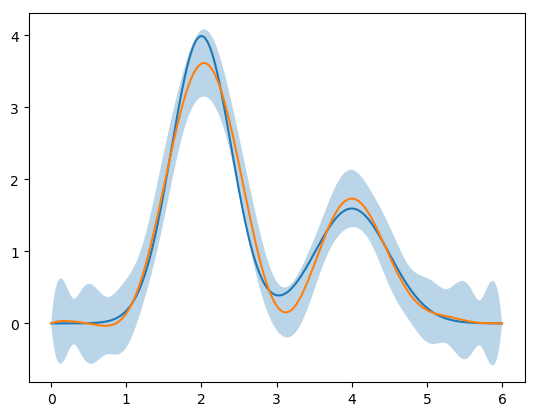

In [9]:
x = collect(range(a, stop=b, length=5000))
plot(x, phi.(x))

phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, call(phivec, x))
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)
# title("Gaussian kernel")
savefig("result.png", dpi=1000)